<a href="https://colab.research.google.com/github/roshan-k-patel/APCOMP2090A-workbooks/blob/master/209a_sec_05_solutions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CS1090a Introduction to Data Science

## Section 5: Bootstrap and Inference for Regression

**Harvard University**<br/>
**Fall 2025**<br/>
**Instructors**: Pavlos Protopapas and Kevin Rader<br/>
**Preceptor**: Chris Gumb
<hr style='height:2px'>

### Introduction

In previous sections, we focused on building models to make predictions. But how confident are we in those predictions? And how much would our model change if we had a slightly different dataset?

**Bootstrapping** is a powerful statistical method that helps us answer these questions. It's a resampling technique that allows us to estimate the uncertainty of any statistic (like a regression coefficient) by simulating the process of drawing multiple datasets from our original data.

In this section, we will:
1. Use bootstrapping to estimate the uncertainty of a simple linear regression model's coefficients.
2. Visualize this uncertainty by plotting multiple bootstrapped regression lines.
3. Calculate a 95% confidence interval (CI) for the slope of our regression line.
4. Calculate a 95% CI for a specific prediction.
5. Compare our bootstrapped CIs to the analytical CIs provided by statistical packages.

In [ ]:
# Data and Stats packages
import numpy as np
import pandas as pd
from sklearn.utils import resample
from scipy.stats import t
import statsmodels.formula.api as smf

# Visualization packages
import matplotlib.pyplot as plt
import seaborn as sns

# Intelligence packages
from sklearn.linear_model import LinearRegression

In [ ]:
import sys
import os

if 'google.colab' in sys.modules:
    # Create the data directory if it doesn't exist
    if not os.path.exists('data'):
        os.makedirs('data')
    # Download the data file if it doesn't exist
    if not os.path.exists('data/camberville_housing.csv'):
        !curl -L "https://github.com/Harvard-CS1090A/2025-public/raw/refs/heads/main/sec05/data/camberville_housing.csv" -o "data/camberville_housing.csv"

### 1. Load and Visualize the Data

We'll use a dataset of housing sales in the Cambridge/Somerville area. Our goal is to model the relationship between the living area (in square feet) and the sale price.

In [ ]:
# Load the dataset
df = pd.read_csv("data/camberville_housing.csv")

# For simplicity, let's focus on houses with reasonable living area and price
df = df[(df['sqft'] > 500) & (df['sqft'] < 5000)]
df = df[(df['price'] > 100_000) & (df['price'] < 4_000_000)]

# Define our predictor (X) and response (y)
X = df[['sqft']]
y = df['price']

df.head()

,date,type,address,city,state,zip,price,beds,baths,neighborhood,sqft,lot,year,hoa,url,mls,latitude,longitude
15,April-28-2025,Condo/Co-op,2 Avon St #5,Cambridge,MA,2138,638000,1,1.0,Cambridge,520,NaN,1909,384.0,https://www.redfin.com/MA/Cambridge/2-Avon-St-...,73342024,42.381622,-71.121892
16,July-28-2025,Condo/Co-op,60 Cross St E #227,Somerville,MA,2145,474900,1,1.0,Assembly Square,532,NaN,2018,257.0,https://www.redfin.com/MA/Somerville/60-Cross-...,73349238,42.390669,-71.084519
17,August-8-2025,Condo/Co-op,7 Mortimer Pl #6,Somerville,MA,2145,400000,1,1.0,Somerville,536,NaN,1970,457.0,https://www.redfin.com/MA/Somerville/7-Mortime...,73389985,42.390245,-71.093766
18,August-8-2025,Condo/Co-op,193 Concord Ave #8,Cambridge,MA,2138,525000,1,1.0,Harvard Square,537,NaN,1900,389.0,https://www.redfin.com/MA/Cambridge/193-Concor...,73408658,42.382310,-71.130623
19,August-14-2025,Condo/Co-op,25 Linden Ave #4,Somerville,MA,2143,470000,1,1.0,Somerville,544,NaN,1970,377.0,https://www.redfin.com/MA/Somerville/25-Linden...,73389110,42.388253,-71.113635


First, let's visualize the relationship between living area and sale price.

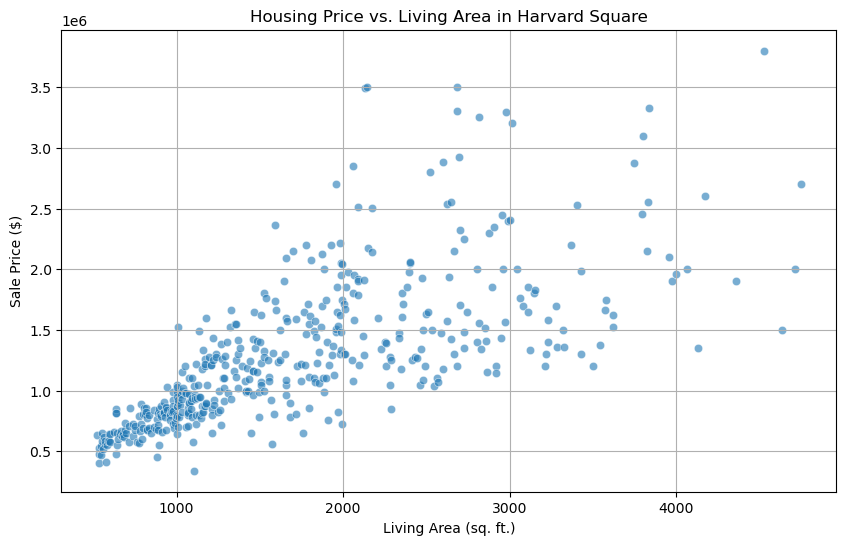

In [ ]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='sqft', y='price', data=df, alpha=0.6)
plt.title('Housing Price vs. Living Area in Harvard Square')
plt.xlabel('Living Area (sq. ft.)')
plt.ylabel('Sale Price ($)')
plt.grid(True)
plt.show()

The scatter plot shows a positive linear relationship, but also reveals non-constant variance (heteroscedasticity)—the variability of sale price increases as living area increases. This is a perfect scenario to use bootstrap, as it doesn't rely on the standard assumptions of linear regression (like constant variance).

### 2. Bootstrap the Regression Model

Now, let's perform the bootstrap procedure. We will repeat the following steps 1,000 times:
1.  **Resample:** Create a new, "bootstrapped" dataset by sampling **with replacement** from our original data. This new dataset will have the same size as the original.
2.  **Fit:** Fit a simple linear regression model on the bootstrapped dataset.
3.  **Store:** Save the slope (`coef_`) and intercept (`intercept_`) of the fitted model.

In [ ]:
B = 1000
boot_slopes = []
boot_intercepts = []

# BEGIN SOLUTION
for i in range(B):
    # Create a bootstrap sample from the dataframe
    df_boot = resample(df, replace=True, n_samples=len(df), random_state=i)

    # Define the predictor and response for the bootstrap sample
    X_boot = df_boot[['sqft']]
    y_boot = df_boot['price']

    # Fit a linear regression model
    model_boot = LinearRegression()
    model_boot.fit(X_boot, y_boot)

    # Store the slope and intercept
    boot_slopes.append(model_boot.coef_[0])
    boot_intercepts.append(model_boot.intercept_)
# END SOLUTION
# BEGIN STUDENT
# for i in range(B):
#     # Create a bootstrap sample from the dataframe
#     df_boot = ...
#
#     # Define the predictor and response for the bootstrap sample
#     X_boot = ...
#     y_boot = ...
#
#     # Fit a linear regression model
#     model_boot = ...
#
#     # Store the slope and intercept
#     ...
#     ...
# END STUDENT

print(f"Completed {B} bootstrap iterations.")
print(f"First 5 slopes: {boot_slopes[:5]}")

Completed 1000 bootstrap iterations.
First 5 slopes: [np.float64(504.72284840861437), np.float64(502.47619102684746), np.float64(482.2286085563791), np.float64(506.0788166192256), np.float64(481.3653581803916)]


### 3. Visualize the Bootstrapped Models

By fitting a model on 1,000 different (but related) datasets, we have effectively simulated 1,000 possible regression lines that our data could have produced. Plotting them all together gives us a visual sense of the model's uncertainty.

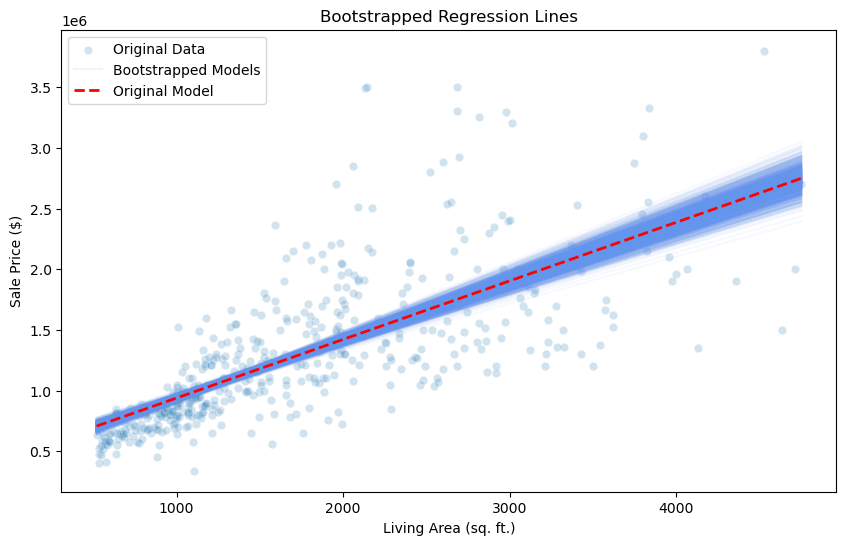

In [ ]:
plt.figure(figsize=(10, 6))

# Plot the original data
sns.scatterplot(x='sqft', y='price', data=df, alpha=0.2, label='Original Data')

# Plot the bootstrapped regression lines
x_range = np.array([X.min(), X.max()])

# Plot one line with a label for the legend
y_range_example = boot_intercepts[0] + boot_slopes[0] * x_range
plt.plot(x_range, y_range_example, color='cornflowerblue', alpha=0.1, label='Bootstrapped Models')
for i in range(1, B):
    y_range = boot_intercepts[i] + boot_slopes[i] * x_range
    plt.plot(x_range, y_range, color='cornflowerblue', alpha=0.05)

# Fit and plot the original model line
original_model = LinearRegression().fit(X, y)
original_y_range = original_model.intercept_ + original_model.coef_[0] * x_range
plt.plot(x_range, original_y_range, color='red', lw=2, linestyle='--', label='Original Model')

plt.title('Bootstrapped Regression Lines')
plt.xlabel('Living Area (sq. ft.)')
plt.ylabel('Sale Price ($)')
plt.legend()
plt.show()

The fan-like shape of the grey lines clearly shows that the model is more uncertain for predictions at the extreme ends of the living area range. Notice also the slight curvature in the data, especially for smaller houses; the straight regression lines seem to systematically overestimate prices for the very smallest houses and underestimate them for slightly larger ones.

### 4. Analyze the Slope's Uncertainty

We now have a distribution of 1,000 possible slopes. We can analyze this distribution to quantify our uncertainty about the true relationship between living area and price.

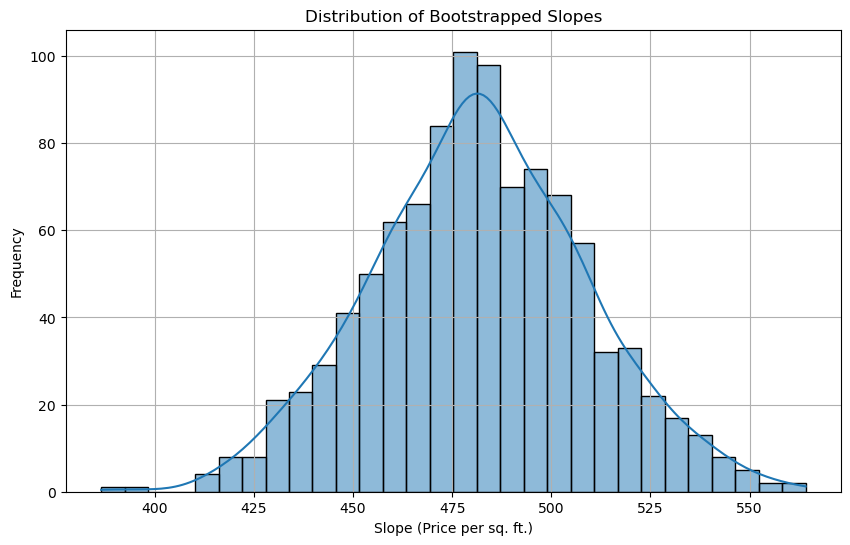

In [ ]:
plt.figure(figsize=(10, 6))
sns.histplot(boot_slopes, bins=30, kde=True)
plt.title('Distribution of Bootstrapped Slopes')
plt.xlabel('Slope (Price per sq. ft.)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

From this distribution, we can calculate a **95% confidence interval** for the slope. This is the range within which we are 95% confident the "true" slope lies. We can find it by taking the 2.5th and 97.5th percentiles of our bootstrapped slopes.

In [ ]:
# BEGIN SOLUTION
# Calculate the 95% confidence interval for the slope
slope_ci = np.percentile(boot_slopes, [2.5, 97.5])
# END SOLUTION
# BEGIN STUDENT
# # Calculate the 95% confidence interval for the slope
# slope_ci = ...
# END STUDENT

print(f"The mean bootstrapped slope is: {np.mean(boot_slopes):.2f}")
print(f"95% Confidence Interval for the slope: [{slope_ci[0]:.2f}, {slope_ci[1]:.2f}]")

The mean bootstrapped slope is: 481.69
95% Confidence Interval for the slope: [428.95, 537.08]


### 5. Confidence Interval for a Prediction

We can also use our bootstrapped models to find a confidence interval for a specific prediction. This is the CI for the *average* price at a given living area, not the range for a single house (which is a prediction interval).

Let's find the 95% CI for the average price of a house with 2,000 sq. ft. of living area.

95% CI for the average price at 2000 sq. ft.: [$1,369,027.35, $1,469,399.92]


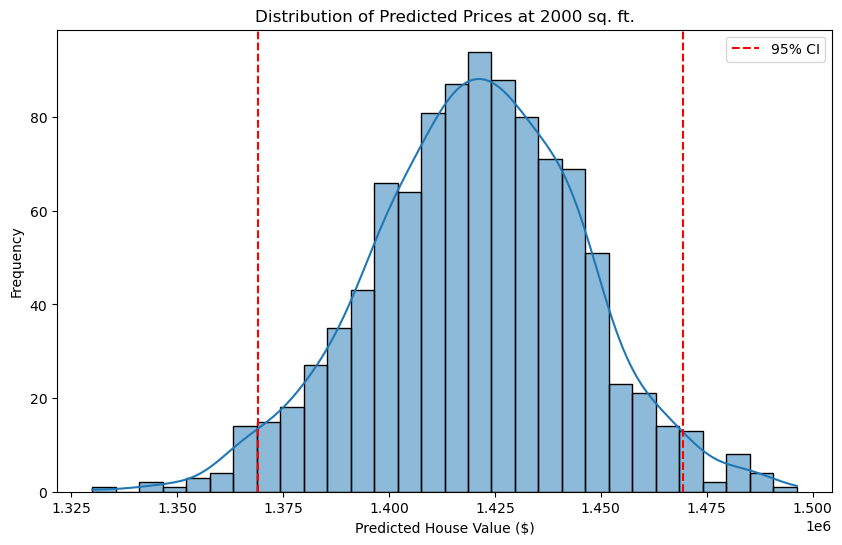

In [ ]:
x_value = 2000
predictions_at_x = []

# BEGIN SOLUTION
# For each bootstrapped model, calculate the prediction at x_value
for i in range(B):
    pred = boot_intercepts[i] + boot_slopes[i] * x_value
    predictions_at_x.append(pred)

# Calculate the 95% confidence interval for the prediction
prediction_ci = np.percentile(predictions_at_x, [2.5, 97.5])
# END SOLUTION
# BEGIN STUDENT
# # For each bootstrapped model, calculate the prediction at x_value
# for i in range(B):
#     pred = ...
#     predictions_at_x.append(pred)
#
# # Calculate the 95% confidence interval for the prediction
# prediction_ci = ...
# END STUDENT

print(f"95% CI for the average price at {x_value} sq. ft.: [${prediction_ci[0]:,.2f}, ${prediction_ci[1]:,.2f}]")

# Plot the distribution of predictions
plt.figure(figsize=(10, 6))
sns.histplot(predictions_at_x, bins=30, kde=True)
plt.title(f'Distribution of Predicted Prices at {x_value} sq. ft.')
plt.xlabel('Predicted House Value ($)')
plt.ylabel('Frequency')
plt.axvline(prediction_ci[0], color='r', linestyle='--', label='95% CI')
plt.axvline(prediction_ci[1], color='r', linestyle='--')
plt.legend()
plt.show()

### 6. Comparison with Analytical Formulas

While `scikit-learn` is excellent for building predictive models, it is not primarily focused on statistical inference. For tasks like calculating confidence intervals, p-values, and other statistical measures, the `statsmodels` library is the standard tool in Python. It provides a rich set of results that are crucial for interpreting the uncertainty of a model's parameters. We use it here to easily get the "textbook" analytical confidence intervals to compare with our bootstrapped results.

---

For simple linear regression, there are mathematical formulas to calculate these confidence intervals. We can use the `statsmodels` library to compute them and compare them to our bootstrapped results.

In [ ]:
# Fit an OLS model using statsmodels
model_sm = smf.ols('price ~ sqft', data=df).fit()

# Print the model summary
print(model_sm.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.506
Model:                            OLS   Adj. R-squared:                  0.504
Method:                 Least Squares   F-statistic:                     467.2
Date:                Tue, 30 Sep 2025   Prob (F-statistic):           6.73e-72
Time:                        19:25:48   Log-Likelihood:                -6599.0
No. Observations:                 459   AIC:                         1.320e+04
Df Residuals:                     457   BIC:                         1.321e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   4.568e+05   4.34e+04     10.525      0.0

In the summary table above, look at the row for `sqft`. The columns `[0.025` and `0.975]` give the analytical 95% CI for the slope.

Now, let's get the analytical CI for the prediction at 2,000 sq. ft.

In [ ]:
# Get the prediction summary frame from statsmodels
pred_summary = model_sm.get_prediction(pd.DataFrame({'sqft': [x_value]})).summary_frame()
display(pred_summary)

,mean,mean_se,mean_ci_lower,mean_ci_upper,obs_ci_lower,obs_ci_upper
0,1.421571e+06,20740.456322,1.380813e+06,1.462330e+06,585197.107783,2.257945e+06


The `mean_ci_lower` and `mean_ci_upper` columns give the analytical 95% CI for the mean response.

In [ ]:
# Extract analytical CIs
analytical_slope_ci = model_sm.conf_int().loc['sqft']
analytical_pred_ci = pred_summary[['mean_ci_lower', 'mean_ci_upper']].iloc[0]

# Create data for the comparison table
comparison_data = {
    "Bootstrap CI": [
        f"[{slope_ci[0]:.2f}, {slope_ci[1]:.2f}]",
        f"[${prediction_ci[0]/1e6:.3f}M, ${prediction_ci[1]/1e6:.3f}M]"
    ],
    "Analytical CI (statsmodels)": [
        f"[{analytical_slope_ci.iloc[0]:.2f}, {analytical_slope_ci.iloc[1]:.2f}]",
        f"[${analytical_pred_ci.iloc[0]/1e6:.3f}M, ${analytical_pred_ci.iloc[1]/1e6:.3f}M]"
    ]
}

# Create and display the DataFrame
comparison_df = pd.DataFrame(comparison_data, index=['Slope', f'Prediction at {x_value} sqft'])
display(comparison_df)

,Bootstrap CI,Analytical CI (statsmodels)
Slope,"[428.95, 537.08]","[438.55, 526.26]"
Prediction at 2000 sqft,"[$1,369,027.35, $1,469,399.92]","[$1,380,812.57, $1,462,329.55]"


The results are very close! Notice that the bootstrapped confidence intervals are slightly wider than the analytical ones. This is common, as the bootstrap makes fewer assumptions (like normality of errors) which the analytical formulas rely on. This demonstrates that bootstrapping provides a reliable way to estimate uncertainty, especially when the assumptions of classical methods are not fully met.

#### A Deeper Dive: The Formulas Behind the CIs (Optional)

The analytical 95% confidence interval for the slope ($\beta_1$) is calculated as:
$$ \hat{\beta}_1 \pm t_{n-2, 0.975} \cdot SE(\hat{\beta}_1) $$
where $SE(\hat{\beta}_1)$ is the standard error of the slope coefficient:
$$ SE(\hat{\beta}_1) = \sqrt{\frac{\hat{\sigma}^2}{\sum_{i=1}^n (x_i - \bar{x})^2}} \quad \text{and} \quad \hat{\sigma}^2 = \frac{\text{RSS}}{n-2} $$
Here, RSS is the Residual Sum of Squares. The term $t_{n-2, 0.975}$ is the critical value from a t-distribution with $n-2$ degrees of freedom that corresponds to a 95% confidence level (i.e., leaving 2.5% in the upper tail, so we look up the 97.5th percentile).

The 95% confidence interval for the mean prediction at a new point $x_0$ is:
$$ \hat{y}_0 \pm t_{n-2, 0.975} \cdot SE(\hat{y}_0) $$
where $SE(\hat{y}_0)$ is the standard error of the mean prediction:
$$ SE(\hat{y}_0) = \hat{\sigma} \sqrt{\frac{1}{n} + \frac{(x_0 - \bar{x})^2}{\sum_{i=1}^n (x_i - \bar{x})^2}} $$

Here are the NumPy calculations for these formulas:

In [ ]:
# Fit the original model again to ensure we have the coefficients
original_model = LinearRegression().fit(X, y)
y_pred = original_model.predict(X)

# Model parameters
n = len(df)
beta_1_hat = original_model.coef_[0]
beta_0_hat = original_model.intercept_

# Calculate RSS and sigma_hat
rss = np.sum((y - y_pred)**2)
sigma_hat = np.sqrt(rss / (n - 2))

# Denominator term for SE formulas
ssx = np.sum((X['sqft'] - X['sqft'].mean())**2)

# --- CI for the Slope ---
se_beta_1 = np.sqrt(sigma_hat**2 / ssx)
t_crit = t.ppf(0.975, df=n-2)
slope_ci_numpy = [beta_1_hat - t_crit * se_beta_1, beta_1_hat + t_crit * se_beta_1]

print("--- Slope CI (NumPy) ---")
print(f"SE(beta_1): {se_beta_1:.4f}")
print(f"t-critical value: {t_crit:.4f}")
print(f"95% CI for slope: [{slope_ci_numpy[0]:.2f}, {slope_ci_numpy[1]:.2f}]")

# --- CI for the Prediction ---
x_0 = 2000.0
y_0_hat = beta_0_hat + beta_1_hat * x_0
se_y_0 = sigma_hat * np.sqrt(1/n + (x_0 - X['sqft'].mean())**2 / ssx)
pred_ci_numpy = [y_0_hat - t_crit * se_y_0, y_0_hat + t_crit * se_y_0]

print("\n--- Prediction CI (NumPy) ---")
print(f"SE(y_hat_0): {se_y_0:.2f}")
print(f"95% CI for prediction at x={x_0:.0f}: [${pred_ci_numpy[0]:,.2f}, ${pred_ci_numpy[1]:,.2f}]")

--- Slope CI (NumPy) ---
SE(beta_1): 22.3172
t-critical value: 1.9652
95% CI for slope: [438.55, 526.26]

--- Prediction CI (NumPy) ---
SE(y_hat_0): 20740.46
95% CI for prediction at x=2000: [$1,380,812.57, $1,462,329.55]


### Conclusion

Bootstrapping is an incredibly versatile tool. We used it here for simple linear regression, but the same principle can be applied to almost any model or statistic. By resampling our data, we can simulate the variability we'd expect to see across different datasets, giving us a robust way to quantify the uncertainty in our models and predictions.

#### A Final Thought: How Could We Improve This Model?

Our analysis revealed a potential weakness in our simple linear model: a systematic bias at lower `sqft` values, suggesting the relationship isn't perfectly linear.

Given what you know about regression, what techniques could you use to capture this curvature and potentially create a better-fitting model? Bootstrapping would remain a valuable tool for assessing the uncertainty of these more complex models.